In [1]:
from __future__ import print_function
#
import os
import glob
import re
import argparse
import pandas as pd
import numpy as np
import subprocess
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm # if use notebook
# from tqdm import tqdm, trange

from threading import Thread, Event
import queue

from PIL import Image
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import imgaug

import random

#from general_function_handler import op_img, call_generator
#from model import create_graph, losses, evaluation, trainning
#import model_2

parser = argparse.ArgumentParser()
parser.add_argument('--gpu_id', default=0)
parser.add_argument('--image_dir', default="./")
parser.add_argument('--save_dir', default='./result')
parser.add_argument('--model_name', default = 'model.ckpt', type=str)
parser.add_argument('--is_training', default=True, type=bool)
parser.add_argument('--batch_size', default=16, type=int)
parser.add_argument('--do_augment', default=True, type = bool)
parser.add_argument('--epochs', default=25, type=int)
parser.add_argument('--lr', default=0.0001, type=float)
parser.add_argument('--image_size', default=(120,120,3), type = int)
parser.add_argument('--n_classes', default=1, type = int)
parser.add_argument('--train_ratio', default=0.9, type = float)
parser.add_argument('--use_model_ckpt', default = None, type = str)
FLAGS = parser.parse_args([])
print(FLAGS)

Namespace(batch_size=16, do_augment=True, epochs=25, gpu_id=0, image_dir='./', image_size=(120, 120, 3), is_training=True, lr=0.0001, model_name='model.ckpt', n_classes=1, save_dir='./result', train_ratio=0.9, use_model_ckpt=None)


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(FLAGS.gpu_id)
import tensorflow as tf

if not os.path.exists(FLAGS.save_dir):
    os.makedirs(FLAGS.save_dir)

model_graph_name = FLAGS.save_dir + '/model.ckpt'
    
graphs_dir = FLAGS.save_dir + '/graphs'
if not os.path.exists(graphs_dir):
    os.makedirs(graphs_dir)

In [3]:
f_train = os.path.join(FLAGS.image_dir, 'parts_train.txt')
f_test = os.path.join(FLAGS.image_dir, 'parts_test.txt')
image_folder = os.path.join(FLAGS.image_dir, 'data128_128', 'inputs')
mask_folder = os.path.join(FLAGS.image_dir, 'data128_128', 'targets_face_only')

# -----------
df_train = pd.read_csv(f_train, header=None)
df_train.columns = ['img_name', 'id']
df_train.id = [str(i).zfill(4) for i in df_train.id]
df_train.img_name = df_train[['img_name', 'id']].apply(lambda x: '_'.join(x) + '.jpg', axis = 1)
df_train['mask_name'] = mask_folder + '/' + df_train.img_name
df_train.img_name = image_folder + '/' + df_train.img_name

df_train, df_val = train_test_split(df_train, test_size = 1-FLAGS.train_ratio)

df_test = pd.read_csv(f_test, header=None)
df_test.columns = ['img_name', 'id']
df_test.id = [str(i).zfill(4) for i in df_test.id]
df_test.img_name = df_test[['img_name', 'id']].apply(lambda x: '_'.join(x) + '.jpg', axis = 1)
df_test['mask_name'] = mask_folder + '/' + df_test.img_name
df_test.img_name = image_folder + '/' + df_test.img_name

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(1800, 3)
(200, 3)
(927, 3)


In [4]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential([
    iaa.Crop(px=(0, 16), name = "Cropper"), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5, name = "Flipper"), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 2.0), name = "GaussuanBlur"), # blur images with a sigma of 0 to 3.0
    iaa.Dropout(0.02, name="Dropout"),
    sometimes(iaa.Affine(
            scale = (0.8,1.2),
            translate_percent = (-0.2, 0.2),
            rotate = (-30, 30),
            order = [0, 1],
            #cval = (0,255),
            mode = 'wrap'
            ))
])

# we only want to execute horizontal crop, flip and affine transformation
# Because we make pairs of images as input (x and y)
def activator_binmasks(images, augmenter, parents, default):
    if augmenter.name in ["GaussianBlur", "Dropout"]:
        return False
    else:
        # default value for all other augmenters
        return default
hooks_binmasks = imgaug.HooksImages(activator=activator_binmasks)

def cv_load_and_resize(x, is_training = True, not_mask = True):
    im_w, im_h, im_c = FLAGS.image_size
    im = cv2.imread(x, not_mask)
    im = cv2.resize(im, (im_w, im_h))
    """
    if FLAGS.do_augment and is_training:
        im = seq.augment_image(im)
    """
    # do preprocessing here
    if not_mask:
        im = preprocessing_func(im)
    else:
        im = im / 255.0
        im = np.expand_dims(im, axis = -1)
    
    return im
    
def preprocessing_func(x):
    # if you got any preprocessing function to do
    return x
    
def get_evalute(dt):
    images = np.array([cv_load_and_resize(i, is_training = False) for i in dt.img_name], dtype=np.float32) # don't do augmentation!
    y_out = np.array([cv_load_and_resize(i, is_training = False, not_mask = False) for i in dt.mask_name], dtype=np.float32) # don't do augmentation!
    # y_out = y_out.astype(np.float32) # never do this, because it is a binary mask
    return images, y_out

In [5]:
def get_train_idx(bz, idp_len_list):
    """ Description 
    Input:
    bz: batch size
    idp_len_list: independent length list 
    
    Output:
    yield index list
    """
    bz_per_class = bz // len(idp_len_list) # To know how many samples should be get for each class
    batch_num = [x // bz_per_class for x in idp_len_list]
    batch_nth = [0] * len(idp_len_list)
    
    select = [list(range(x)) for x in idp_len_list]
    
    for s in select:
        random.shuffle(s)
    
    while True:
        idxs = []
        for i in range(len(idp_len_list)):
            if batch_nth[i] >= batch_num[i]:
                batch_nth[i] = 0
                random.shuffle(select[i])
            idx = select[i][batch_nth[i] * bz_per_class: (batch_nth[i] + 1) * bz_per_class]
            batch_nth[i] += 1
            idxs.append(idx)
        yield idxs
    
def get_train_data(queue, df_list):
    while True:
        idxs = queue.get()
        
        select_list = []
        
        for df, idx in zip(df_list, idxs):
            select_list.append(df.iloc[idx])
        select_list = pd.concat(select_list)
        #print(select_list)
        augmentation_seq_deterministic = seq.to_deterministic()
        images = np.array([cv_load_and_resize(iid) for iid in select_list.img_name], dtype=np.float32)
        images = augmentation_seq_deterministic.augment_images(images)
        
        bimask = np.array([cv_load_and_resize(iid, is_training = False, not_mask = False) for iid in select_list.mask_name], dtype=np.float32)
        bimask = augmentation_seq_deterministic.augment_images(bimask, hooks = hooks_binmasks)
        
        images = images.astype(np.float32)
        #bimask = bimask.astype(np.float32)
        
        yield images, bimask

        
def enqueue(queue, stop, gen_func, args):
    gen = gen_func(*args)
    while True:
        if stop.is_set():
            return
        queue.put(next(gen))

In [6]:
train_queue = queue.Queue(maxsize=3)
train_idx_queue = queue.Queue(maxsize=25)

### to stop threads after training
events = []

### enqueue training index 
event = Event()
thread = Thread(target=enqueue, 
                args= (train_idx_queue, 
                       event, 
                       get_train_idx, 
                       (FLAGS.batch_size, [len(df_train)])
                                      ))
thread.start()
events.append(event)

### enqueue train batch
for i in range(6):
    event = Event()
    thread = Thread(target=enqueue, 
                    args = (train_queue,
                            event, 
                            get_train_data, 
                            (train_idx_queue, [df_train])
                   ))
    thread.start()
    events.append(event)

a,b = train_queue.get()
print(a.shape)
print(b.shape)
x_val, y_val = get_evalute(df_val)
print(x_val.shape)
print(a.shape, b.shape)

(16, 120, 120, 3)
(16, 120, 120, 1)
(200, 120, 120, 3)
(16, 120, 120, 3) (16, 120, 120, 1)


In [7]:
class EarlyStopping():
    def __init__(self, patience, min_delta = 0.0001):
        # validation loss should at least be less than current min_loss - min_delta
        self.min_delta = min_delta 
        self.patience = patience
        self.epoch_count = 0
        self.min_loss = None
        self.stop = False
        
    def on_epoch_end(self, val_loss, *args, **kwargs):
        if self.min_loss is None or val_loss < self.min_loss - self.min_delta:
            self.min_loss = val_loss
            self.epoch_count = 0
        else:
            self.epoch_count += 1
            
        # if cumulative counts is larger than our patience, set the stop signal to True
        if self.epoch_count >= self.patience:
            self.stop = True
        
class Model_checkpoint():
    def __init__(self, model_name, save_best_only = True):
        self.min_loss = None
        self.model_name = model_name
        self.save_best_only = save_best_only
        
    def on_epoch_end(self, val_loss, nth_epoch, saver, sess, *args, **kwargs):
        if self.min_loss is None or val_loss < self.min_loss:
            self.min_loss = val_loss
            saver.save(sess, 
                       self.model_name + '.ckpt')
        if not self.save_best_only:
            saver.save(sess, 
                       self.model_name + '_' + str(nth_epoch) + '.ckpt',
                       global_step=nth_epoch)
        
class ReduceLROnPlateau():
    def __init__(self, lr, factor, patience, min_lr = 1e-10):
        self.lr = lr
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.min_loss = None
        self.epoch_count = 0
    
    def on_epoch_end(self, val_loss, *args, **kwargs):
        if self.min_loss is None or val_loss < self.min_loss:
            epoch_count = 0
            self.min_loss = val_loss
        else:
            self.epoch_count += 1
        
        if self.epoch_count == self.patience:
            self.lr *= self.factor
            self.epoch_count = 0
            
            if self.lr <= self.min_lr:
                self.lr = self.min_lr

class Run_collected_functions():
    def __init__(self, callback_dicts):
        self.on_session_begin = callback_dicts['on_session_begin']
        self.on_session_end = callback_dicts['on_session_end']
        self.on_batch_begin = callback_dicts['on_batch_begin']
        self.on_batch_end = callback_dicts['on_batch_end']
        self.on_epoch_begin = callback_dicts['on_epoch_begin']
        self.on_epoch_end = callback_dicts['on_epoch_end']
        
    def run_on_epoch_end(self, val_loss, nth_epoch = None, sess = None, saver = None):
        for func in self.on_epoch_end:
            getattr(func, 'on_epoch_end')(val_loss = val_loss,
                                          nth_epoch = nth_epoch,
                                          sess = sess,
                                          saver = saver)
        
    def on_session_end(self, *args, **kwargs):
        pass

In [8]:
im_w, im_h, im_c = FLAGS.image_size

""" Controling variables """
global_step = tf.Variable(0, name='global_step',trainable=False)
is_training = tf.get_variable('is_training', [], trainable=False)

""" Input and holder"""
x_holder = tf.keras.layers.Input(shape = (im_w, im_h, im_c))
y_holder = tf.placeholder(tf.float32, shape=[None, im_w, im_h, FLAGS.n_classes])

# Down-stream
with tf.name_scope('Down-stream-block1'):
    c1 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64,
                                  strides=(1,1), 
                                  activation= tf.nn.selu,
                                  padding='same', name = 'c1_1')(x_holder)
    c1 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64,
                                  strides=(2,2), 
                                  activation= tf.nn.selu,
                                  padding='same', name = 'c1_2')(c1)

with tf.name_scope('Down-stream-block2'):
    c2 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128,
                                  strides=(1,1), 
                                  activation= tf.nn.selu,
                                  padding='same', name = 'c2_1')(c1)
    c2 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128,
                                  strides=(2,2), 
                                  activation= tf.nn.selu,
                                  padding='same', name = 'c2_2')(c2)
with tf.name_scope('Down-stream-block3'):
    c3 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256,
                              strides=(1,1), 
                              activation= tf.nn.selu,
                              padding='same', name = 'c3_1')(c2)
    c3 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256,
                              strides=(2,2), 
                              activation= tf.nn.selu,
                              padding='same', name = 'c3_2')(c3)
# Up-stream
with tf.name_scope("Up-stream-block1"):
    d3 = tf.keras.layers.UpSampling2D()(c3)
    d3 = tf.keras.layers.Conv2D(kernel_size=(3,3), 
                                  filters=128, 
                                  activation = tf.nn.selu,
                                  strides=(1,1), 
                                  padding='same', name='deconv_1_1')(d3)
    d3 = tf.keras.layers.concatenate([d3, c2])
    d3 = tf.keras.layers.Conv2D(kernel_size=(3,3), 
                                         filters=128, 
                                         strides=(1,1), 
                                         activation = tf.nn.selu,
                                         padding='same', name = 'deconv_1_2')(d3)

with tf.name_scope("Up-stream-block3"):
    d2 = tf.keras.layers.UpSampling2D()(d3)
    d2 = tf.keras.layers.Conv2D(kernel_size=(3,3), 
                                  filters=64, 
                                  activation = tf.nn.selu,
                                  strides=(1,1), 
                                  padding='same', name='deconv_2_1')(d2)
    d2 = tf.keras.layers.concatenate([d2, c1])
    d2 = tf.keras.layers.Conv2D(kernel_size=(3,3), 
                                         filters=64, 
                                         strides=(1,1), 
                                         activation = tf.nn.selu,
                                         padding='same', name = 'deconv_2_2')(d2)
    
out = tf.keras.layers.UpSampling2D()(d2)
out = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=1, 
                             strides=(1,1), 
                             activation = 'linear',
                             padding='same', name='out')(out)

def pixelwise_rmse(y_true, y_pred):
    #input / output shape = im_w, im_h, 1 (binary mask)
    loss = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
    #loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return loss
loss1 = pixelwise_rmse(y_true = y_holder, y_pred = out)
"""
with tf.name_scope('compute_loss'):
    loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_holder, logits=out))
"""
lr_holder = tf.placeholder(dtype=tf.float16, shape=[], name='learning_rate_controller')
optim = tf.train.AdamOptimizer(learning_rate=lr_holder)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optim_op = optim.minimize(loss1, global_step = global_step)

In [9]:
n_batch = 200
# -------------------------- #
global_train_loss = []
global_valid_loss = []
early_stop = EarlyStopping(patience=10)
model_checkpt = Model_checkpoint(model_name=model_graph_name, save_best_only=True)
reduce_lr = ReduceLROnPlateau(lr=FLAGS.lr, factor=0.5, patience=5)

callback_dict = {
    'on_session_begin':[], # start of a session
    'on_batch_begin':[], # start of a training batch
    'on_batch_end':[], # end of a training batch
    'on_epoch_begin':[], # start of a epoch
    'on_epoch_end':[early_stop, reduce_lr], # end of a epoch
    'on_session_end':[] # end of a session
    }
callback_manager = Run_collected_functions(callback_dict)

with tf.Session() as sess:
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(FLAGS.save_dir + '/graphs', sess.graph)
    tf.train.write_graph(sess.graph_def, FLAGS.save_dir, 'model.pb', as_text=True) # save the graph
    
    sess.run([tf.global_variables_initializer()])
    for i in range(FLAGS.epochs):
        train_epoch_loss= []
        
        train_batch_bar = tqdm(range(n_batch), desc = 'Training Batch', unit='batch')
        for j in train_batch_bar:
            x_, y_ = train_queue.get()
            
            batch_loss, _ = sess.run([loss1, optim_op], feed_dict = {
                x_holder: x_, 
                y_holder: y_, 
                lr_holder: reduce_lr.lr,
                tf.keras.backend.learning_phase(): 1,
                #is_training: True
            })
            train_epoch_loss.append(batch_loss)
            current_train_loss = np.mean(train_epoch_loss)
            train_batch_bar.set_description('Training loss: %.2f' % (current_train_loss))
        
        global_train_loss.append(current_train_loss)
        valid_epoch_loss = []
        
        valid_batch_bar = tqdm(range(len(df_val) // FLAGS.batch_size + 1), desc = "Validation Batch", unit='batch')
        for j in valid_batch_bar:
            this_val_loss, tmp = sess.run([loss1, out], feed_dict = {
                x_holder: x_val[j*FLAGS.batch_size : (j+1) * FLAGS.batch_size], 
                y_holder: y_val[j*FLAGS.batch_size : (j+1) * FLAGS.batch_size],
                tf.keras.backend.learning_phase(): 0,
                #is_training: False,
            } )
            valid_epoch_loss.append(this_val_loss)
            valid_batch_bar.set_description('Validation loss: %.2f' % (this_val_loss))
        current_valid_loss = np.mean(valid_epoch_loss)
        
        global_valid_loss.append(current_valid_loss)
        
        callback_manager.run_on_epoch_end(val_loss = current_valid_loss,
                                          sess = sess,
                                          saver = saver,
                                          nth_epoch = i)
        if early_stop.stop:
            print("EarlyStop!")
            break

KeyboardInterrupt: 

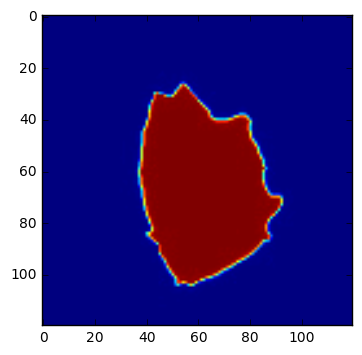

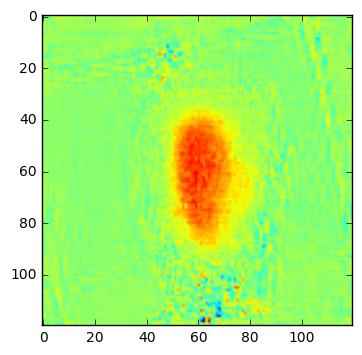

In [10]:
plt.imshow(y_val[0,:,:,0])
plt.show()
plt.imshow(tmp[0,:,:,0])
plt.show()

In [ ]:
xx = tf.constant([0.22, 0.15, 0.55])
proc = tf.nn.softmax(xx)

with tf.Session() as sess:
    yy = sess.run(proc)
    

In [ ]:
t

In [ ]:
a = np.array([[1,2,3], [4,5,6]])
b = np.array([[3,2,1], [7,8,7]])

a-b